In [1]:
%matplotlib inline



EEG processing and Event Related Potentials (ERPs)
==================================================

For a generic introduction to the computation of ERP and ERF
see `tut_epoching_and_averaging`. Here we cover the specifics
of EEG, namely:

    - setting the reference
    - using standard montages :func:`mne.channels.Montage`
    - Evoked arithmetic (e.g. differences)




In [2]:
import mne
from mne.datasets import sample

Setup for reading the raw data



In [3]:
data_path = "/Users/basilminkov/Desktop/Neuroimaging/Data/MNE-sample-data/"
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
raw = mne.io.read_raw_fif(raw_fname, preload=True)
# raw.set_eeg_reference('average', projection=True)  # set EEG average reference

Opening raw data file /Users/basilminkov/Desktop/Neuroimaging/Data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


Let's restrict the data to the EEG channels



In [4]:
raw.pick_types(meg=False, eeg=True, eog=True)

<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 60 x 41700 (277.7 sec), ~22.1 MB, data loaded>

By looking at the measurement info you will see that we have now
59 EEG channels and 1 EOG channel



In [5]:
print(raw.info)

<Info | 19 non-empty fields
    bads : 'list | 0 items
    buffer_size_sec : 'numpy.float64 | 13.3196808772
    ch_names : 'list | EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, ...
    chs : 'list | 60 items (EEG: 59, EOG: 1)
    comps : 'list | 0 items
    custom_ref_applied : 'bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    dig : 'list | 146 items
    events : 'list | 0 items
    file_id : 'dict | 4 items
    highpass : 'float | 0.10000000149011612 Hz
    hpi_meas : 'list | 1 items
    hpi_results : 'list | 1 items
    lowpass : 'float | 40.0 Hz
    meas_date : 'numpy.ndarray | 2002-12-03 22:01:10
    meas_id : 'dict | 4 items
    nchan : 'int | 60
    projs : 'list | PCA-v1: off, PCA-v2: off, PCA-v3: off, ...
    sfreq : 'float | 150.15374755859375 Hz
    acq_pars : 'NoneType
    acq_stim : 'NoneType
    ctf_head_t : 'NoneType
    description : 'NoneType
    dev_ctf_t : 'NoneType
    experimenter : 'NoneType
    hpi_subsystem : 'NoneType
    kit_system_

In practice it's quite common to have some EEG channels that are actually
EOG channels. To change a channel type you can use the
:func:`mne.io.Raw.set_channel_types` method. For example
to treat an EOG channel as EEG you can change its type using



In [6]:
raw.set_channel_types(mapping={'EOG 061': 'eeg'})
print(raw.info)

<Info | 19 non-empty fields
    bads : 'list | 0 items
    buffer_size_sec : 'numpy.float64 | 13.3196808772
    ch_names : 'list | EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, ...
    chs : 'list | 60 items (EEG: 60)
    comps : 'list | 0 items
    custom_ref_applied : 'bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    dig : 'list | 146 items
    events : 'list | 0 items
    file_id : 'dict | 4 items
    highpass : 'float | 0.10000000149011612 Hz
    hpi_meas : 'list | 1 items
    hpi_results : 'list | 1 items
    lowpass : 'float | 40.0 Hz
    meas_date : 'numpy.ndarray | 2002-12-03 22:01:10
    meas_id : 'dict | 4 items
    nchan : 'int | 60
    projs : 'list | PCA-v1: off, PCA-v2: off, PCA-v3: off, ...
    sfreq : 'float | 150.15374755859375 Hz
    acq_pars : 'NoneType
    acq_stim : 'NoneType
    ctf_head_t : 'NoneType
    description : 'NoneType
    dev_ctf_t : 'NoneType
    experimenter : 'NoneType
    hpi_subsystem : 'NoneType
    kit_system_id : 'No

And to change the nameo of the EOG channel



In [7]:
raw.rename_channels(mapping={'EOG 061': 'EOG'})

Let's reset the EOG channel back to EOG type.



In [8]:
raw.set_channel_types(mapping={'EOG': 'eog'})

The EEG channels in the sample dataset already have locations.
These locations are available in the 'loc' of each channel description.
For the first channel we get



In [9]:
print(raw.info['chs'][0]['loc'])

[-0.03737009  0.10568011  0.07333875  0.00235201  0.11096951 -0.03500458
  0.          1.          0.          0.          0.          1.        ]


And it's actually possible to plot the channel locations using
:func:`mne.io.Raw.plot_sensors`.



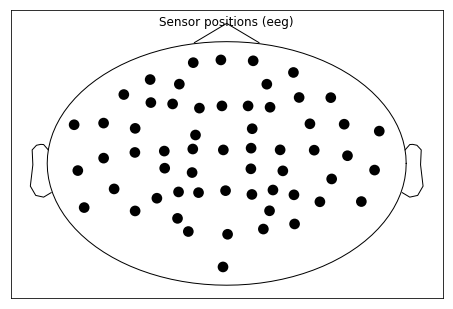

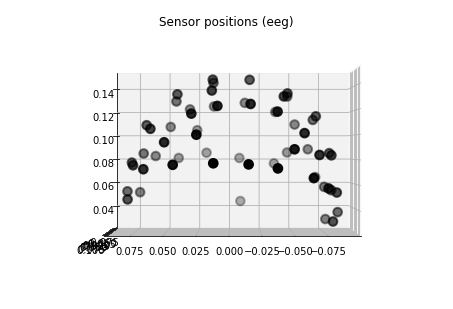

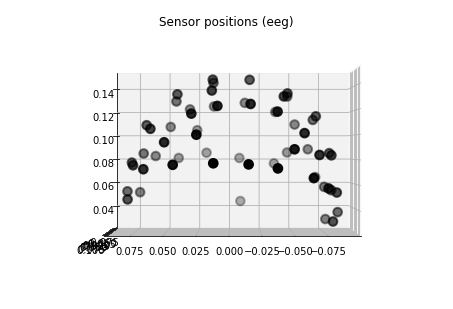

In [10]:
raw.plot_sensors()
raw.plot_sensors('3d')  # in 3D

Setting EEG montage
-------------------

In the case where your data don't have locations you can set them
using a :class:`mne.channels.Montage`. MNE comes with a set of default
montages. To read one of them do:



In [11]:
montage = mne.channels.read_montage('standard_1020')
print(montage)

<Montage | standard_1020 - 97 channels: LPA, RPA, Nz ...>


To apply a montage on your data use the ``set_montage`` method.
function. Here don't actually call this function as our demo dataset
already contains good EEG channel locations.

Next we'll explore the definition of the reference.



Setting EEG reference
---------------------

Let's first remove the reference from our Raw object.

This explicitly prevents MNE from adding a default EEG average reference
required for source localization.



In [12]:
raw_no_ref, _ = mne.set_eeg_reference(raw, [])

EEG data marked as already having the desired reference. Preventing automatic future re-referencing to an average reference.
Removing existing average EEG reference projection.


We next define Epochs and compute an ERP for the left auditory condition.



72 matching events found
3 projection items activated
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EEG : ['EEG 007']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EOG : ['EOG']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']


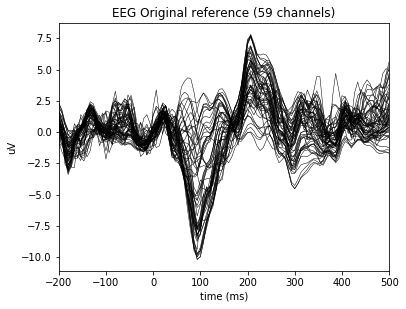

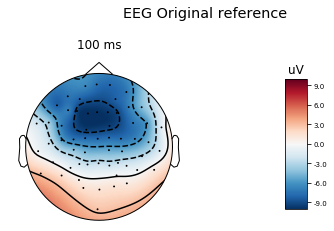

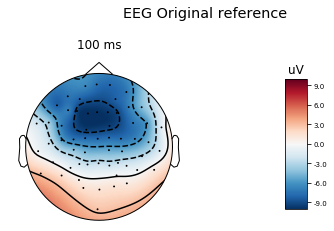

In [13]:
reject = dict(eeg=180e-6, eog=150e-6)
event_id, tmin, tmax = {'left/auditory': 1}, -0.2, 0.5
events = mne.read_events(event_fname)
epochs_params = dict(events=events, event_id=event_id, tmin=tmin, tmax=tmax,
                     reject=reject)

evoked_no_ref = mne.Epochs(raw_no_ref, **epochs_params).average()
del raw_no_ref  # save memory

title = 'EEG Original reference'
evoked_no_ref.plot(titles=dict(eeg=title))
evoked_no_ref.plot_topomap(times=[0.1], size=3., title=title)

**Average reference**: This is normally added by default, but can also
be added explicitly.



In [18]:
# raw_car, _ = mne.set_eeg_reference(inst=raw, ref_channels='average')
# evoked_car = mne.Epochs(raw_car, **epochs_params).average()
# del raw_car  # save memory

title = 'EEG Average reference'
evoked_car.plot(titles=dict(eeg=title))
evoked_car.plot_topomap(times=[0.1], size=3., title=title)

NameError: name 'evoked_car' is not defined

**Custom reference**: Use the mean of channels EEG 001 and EEG 002 as
a reference



In [ ]:
raw_custom, _ = mne.set_eeg_reference(raw, ['EEG 001', 'EEG 002'])
evoked_custom = mne.Epochs(raw_custom, **epochs_params).average()
del raw_custom  # save memory

title = 'EEG Custom reference'
evoked_custom.plot(titles=dict(eeg=title))
evoked_custom.plot_topomap(times=[0.1], size=3., title=title)

Evoked arithmetics
------------------

Trial subsets from Epochs can be selected using 'tags' separated by '/'.
Evoked objects support basic arithmetic.
First, we create an Epochs object containing 4 conditions.



In [ ]:
event_id = {'left/auditory': 1, 'right/auditory': 2,
            'left/visual': 3, 'right/visual': 4}
epochs_params = dict(events=events, event_id=event_id, tmin=tmin, tmax=tmax,
                     reject=reject)
epochs = mne.Epochs(raw, **epochs_params)

print(epochs)

Next, we create averages of stimulation-left vs stimulation-right trials.
We can use basic arithmetic to, for example, construct and plot
difference ERPs.



In [ ]:
left, right = epochs["left"].average(), epochs["right"].average()

# create and plot difference ERP
mne.combine_evoked([left, -right], weights='equal').plot_joint()

This is an equal-weighting difference. If you have imbalanced trial numbers,
you could also consider either equalizing the number of events per
condition (using
:meth:`epochs.equalize_event_counts <mne.Epochs.equalize_event_counts>`).
As an example, first, we create individual ERPs for each condition.



In [ ]:
aud_l = epochs["auditory", "left"].average()
aud_r = epochs["auditory", "right"].average()
vis_l = epochs["visual", "left"].average()
vis_r = epochs["visual", "right"].average()

all_evokeds = [aud_l, aud_r, vis_l, vis_r]
print(all_evokeds)

This can be simplified with a Python list comprehension:



In [ ]:
all_evokeds = [epochs[cond].average() for cond in sorted(event_id.keys())]
print(all_evokeds)

# Then, we construct and plot an unweighted average of left vs. right trials
# this way, too:
mne.combine_evoked(all_evokeds,
                   weights=(0.25, -0.25, 0.25, -0.25)).plot_joint()

Often, it makes sense to store Evoked objects in a dictionary or a list -
either different conditions, or different subjects.



In [ ]:
# If they are stored in a list, they can be easily averaged, for example,
# for a grand average across subjects (or conditions).
grand_average = mne.grand_average(all_evokeds)
mne.write_evokeds('/tmp/tmp-ave.fif', all_evokeds)

# If Evokeds objects are stored in a dictionary, they can be retrieved by name.
all_evokeds = dict((cond, epochs[cond].average()) for cond in event_id)
print(all_evokeds['left/auditory'])

# Besides for explicit access, this can be used for example to set titles.
for cond in all_evokeds:
    all_evokeds[cond].plot_joint(title=cond)